Importing packages

In [1]:
from keras.datasets import cifar10
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from matplotlib import pyplot as plt
from skimage import feature
from scipy.stats import itemfreq
from scipy.spatial.distance import euclidean
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as prepr

Using TensorFlow backend.


Loading data: training set + labels, test set + labels

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Dividing training data into training and validation set

In [144]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2)

Showing one example image from the database

(-0.5, 31.5, 31.5, -0.5)

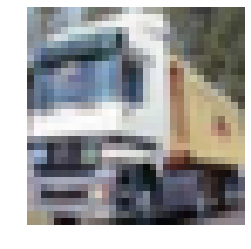

In [36]:
plt.imshow(x_train[1])
plt.axis('off')

### RGB histogram over the whole image 

In [37]:
def get_rgb(data, histsize):
    rgb_array = np.zeros((len(data), histsize * 3))
    for j in range(len(data)):
        img = data[j]
        color = ('r','g','b')
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[histsize],[0,256])
            rgb_array[j, i*histsize:(i+1)*histsize] = histr.flatten()
    
    return rgb_array

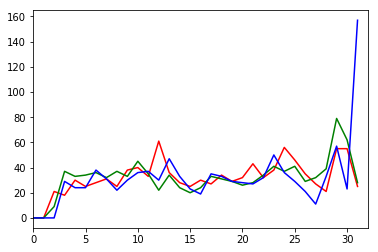

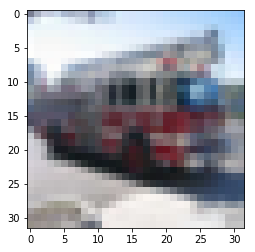

In [142]:
features_x_train_rgb = get_rgb(X_train, 32)
col = ('r', 'g', 'b')
plt.plot(features_x_train_rgb[0,0:32], 'r')
plt.plot(features_x_train_rgb[0,32:64], 'g')
plt.plot(features_x_train_rgb[0,64:], 'b')
plt.xlim([0,32])
plt.show()
plt.imshow(X_train[0])

In [145]:
features_x_val_rgb = get_rgb(X_val, 32)

### Local Binary Patterns representation

In [46]:
def get_lbp(data, radius, numPoints):
    ImageSize = 128
    features = np.zeros((len(data), numPoints+2))
    for j in range(len(data)):
        gray = cv2.cvtColor(data[j], cv2.COLOR_RGB2GRAY)
        gray  = cv2.resize(gray, (ImageSize, ImageSize), interpolation=cv2.INTER_CUBIC)
        lbp = feature.local_binary_pattern(gray, numPoints, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
        bins=np.arange(0, numPoints + 3),
        range=(0, numPoints + 2))
        hist = hist.astype("float")
        hist /= (hist.sum())
        features[j] = hist
    return features

In [146]:
radius = 2
numPoints = radius * 8
features_x_train_lbp = get_lbp(X_train, radius, numPoints)
features_x_val_lbp = get_lbp(X_val, radius, numPoints)

### HOG representation

In [48]:
def get_HOG(data):
    features = np.zeros((len(data), 20736))
    blockSize = (8,8)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    winStride = (8,8)
    padding = (8,8)
    nlevels = 64
    for i in range(len(data)):
        image = data[i]
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)
        winSize = (image.shape[1], image.shape[0])
    
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
        #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    
        locations = [] # (10, 10)# ((10,20),)
        hist = hog.compute(image,winStride,padding,locations)
        features[i] = hist.flatten()
    return features

In [147]:
features_x_train_HOG = get_HOG(X_train)    
features_x_val_HOG = get_HOG(X_val) 

### Pretrained Keras network VGG16 - no training

Here, I download only the model's convolutional part to compute the feature representation of the training images

In [59]:
model_b = VGG16(weights='imagenet', include_top=False)

In [58]:
def get_VGG16(data, model):
    features = np.zeros((len(data),512))
    for i in range(len(data)):
        #img = cv2.resize(data[i], (ImageSize, ImageSize), interpolation=cv2.INTER_CUBIC)
        x = image.img_to_array(data[i])
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        extracted = model.predict(x)
        features[i] = extracted.flatten()
    return features

In [148]:
features_x_train_VGG16 = get_VGG16(X_train, model_b)
features_x_val_VGG16 = get_VGG16(X_val, model_b)

### Pretrained Keras model with training on the cifar-10 dataset

preprocessing images and labels

In [4]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical


X_train_v = preprocess_input(x_train)
Y_train_v = to_categorical(y_train)


# We one-hot-encode the labels for training
X_test_v = preprocess_input(x_test)
Y_test_v = to_categorical(y_test)

Model definition

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(
    weights=None, 
    include_top=True, 
    classes=10,
    input_shape=(32,32,3)
)

# Expand this cell for the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

Compiling the model

In [6]:
from tensorflow.keras import optimizers

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Training the model on the cifar-10 dataset (80% was used for training, 20% for validation)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

# Train the model
history = model.fit(
    x=X_train_v,
    y=Y_train_v,
    validation_split=0.2,
    batch_size=256,
    epochs=30,
    callbacks=[checkpoint],
    verbose=1
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 56s 1ms/step - loss: 2.2513 - acc: 0.1505 - val_loss: 2.1605 - val_acc: 0.2040
Epoch 2/30
40000/40000 [==============================] - 48s 1ms/step - loss: 2.0341 - acc: 0.2588 - val_loss: 2.5039 - val_acc: 0.1659
Epoch 3/30
40000/40000 [==============================] - 49s 1ms/step - loss: 1.8775 - acc: 0.3197 - val_loss: 1.7986 - val_acc: 0.3452
Epoch 4/30
40000/40000 [==============================] - 49s 1ms/step - loss: 1.7507 - acc: 0.3660 - val_loss: 1.9626 - val_acc: 0.3152
Epoch 5/30
40000/40000 [==============================] - 49s 1ms/step - loss: 1.6439 - acc: 0.4063 - val_loss: 1.6409 - val_acc: 0.4181
Epoch 6/30
40000/40000 [==============================] - 49s 1ms/step - loss: 1.5507 - acc: 0.4369 - val_loss: 1.5256 - val_acc: 0.4419
Epoch 7/30
40000/40000 [==============================] - 49s 1ms/step - loss: 1.4824 - acc: 0.4674 - val_loss: 1.5894 - val_acc

Plotting the training and validation loss and accuracy

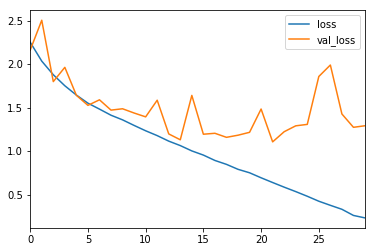

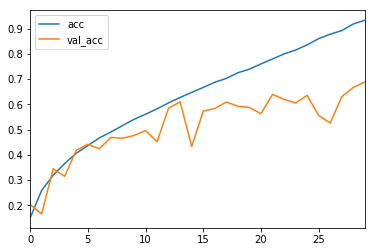

In [12]:
import json
import pandas as pd
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [14]:
model.load_weights('model.h5')
train_loss, train_score = model.evaluate(X_train_v, Y_train_v)
test_loss, test_score = model.evaluate(X_test_v, Y_test_v)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Train F1 Score:", train_score)
print("Test F1 Score:", test_score)

10000/10000 [==============================] - 7s 656us/step
Train Loss: 0.4050728114426136
Test Loss: 1.3388730659484864
Train F1 Score: 0.88776
Test F1 Score: 0.6871


Using the trained model to get the feature representation of the images

In [24]:
def get_VGG16_trained(data, sub_model):
    features = np.zeros((len(data), 512))
    for i in range(len(data)):
        x = image.img_to_array(x_train[i])
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        f = sub_model.predict(x).flatten()
        features[i] = f
    return features

    

In [26]:
from tensorflow.keras.models import Model
sub_model = Model(inputs=model.input, outputs=model.get_layer('block5_pool').output)

features_x_train_vgg_tr = get_VGG16_trained(x_train[:40000], sub_model)
features_x_val_vgg_tr = get_VGG16_trained(x_train[40000:], sub_model)

In [27]:
def calc_eucl(v1, v2):
    return euclidean(v1,v2)

Showing the histograms of the Euclidean distances between similar and different images in order to set the threshold values

In [164]:
def show_hist(features, num, Y_train):
    sim=[]
    diff=[]
    for i in range(num):
        for j in range(num):
            if i!=j:
                eucl = calc_eucl(features[i], features[j])
                if Y_train[i] == Y_train[j]:
                    sim.append(eucl)
                else:
                    diff.append(eucl)
    plt.hist(sim, bins=50, density=True)
    plt.hist(diff,  bins=50, density=True, alpha=0.5)
    plt.show()

Histograms of euclidean distances of similar and different images based on RGB representation

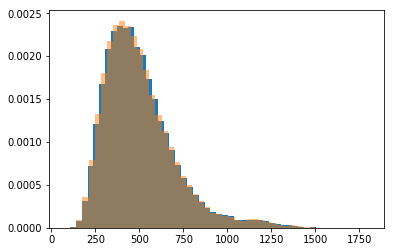

In [165]:
show_hist(features_x_train_rgb, 1000, Y_train)

Histograms of euclidean distances of similar and different images based on LBP representation

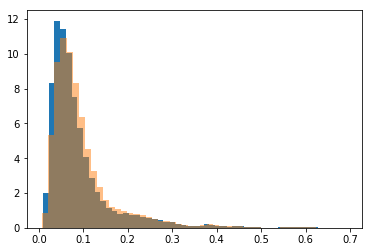

In [166]:
show_hist(features_x_train_lbp, 1000, Y_train)

Histograms of euclidean distances of similar and different images based on HOG representation

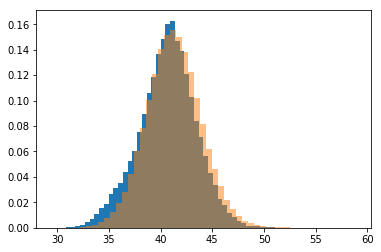

In [167]:
show_hist(features_x_train_HOG, 1000, Y_train)

Histograms of euclidean distances of similar and different images based on untrained VGG16 representation

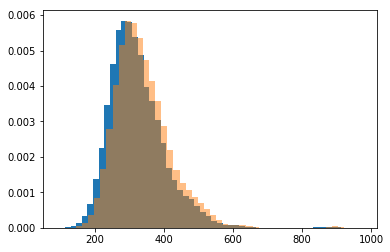

In [153]:
show_hist(features_x_train_VGG16, 1000, Y_train)

Histograms of euclidean distances of similar and different images based on trained VGG16 representation

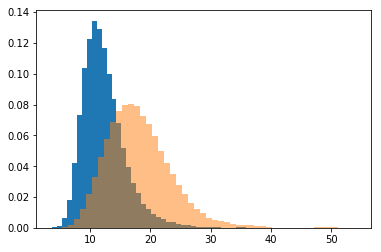

In [168]:
show_hist(features_x_train_vgg_tr, 1000, y_train)

Calculating precision and recall on a subset of the images

In [155]:
def get_metrics(features, th, num, name, y_train):
    total = 0
    correct = 0
    sim = 0
    for i in range(num):
        for j in range(num):
            if i!=j:
                eucl = calc_eucl(features[i], features[j])
                if eucl <= th:
                    total += 1
                    if y_train[i] == y_train[j]:
                        correct += 1
                if y_train[i] == y_train[j]:
                    sim +=1
    print(name)
    print('Precision: ', correct/total)
    print('Recall: ', correct/sim) 

In [176]:
get_metrics(features_x_val_rgb, 350, 100, 'RGB',Y_val)   
get_metrics(features_x_val_lbp, 0.06, 100, 'LBP',Y_val) 
get_metrics(features_x_val_HOG, 41, 100, 'HOG',Y_val) 
get_metrics(features_x_val_VGG16, 290, 100, 'VGG16 untrained', Y_val) 
get_metrics(features_x_train_vgg_tr, 14, 100, 'VGG16 trained', y_train) 

RGB
Precision:  0.11271676300578035
Recall:  0.24074074074074073
LBP
Precision:  0.10116731517509728
Recall:  0.32098765432098764
HOG
Precision:  0.10743801652892562
Recall:  0.5349794238683128
VGG16 untrained
Precision:  0.14593535749265427
Recall:  0.3065843621399177
VGG16 trained
Precision:  0.2533783783783784
Recall:  0.7281553398058253


Precision-recall curves for class 1

In [174]:
Y_val_1 = Y_val.copy()
Y_val_1[Y_val==1] = 1
Y_val_1[Y_val!=1] = 0

y_train_1 = y_train.copy()
y_train_1[y_train==1] = 1
y_train_1[y_train!=1] = 0

In [171]:
def get_probs(features, th, num, y_train, Y_train_1):
    y_true = []
    probs = []
    for i in range(100):
        if Y_train_1[i] == 1:
            for j in range(i+1,100):
                if i!=j:
                    if y_train[i] == y_train[j]:
                        y_true.append(1)
                    else:
                        y_true.append(0)
                    eucl = calc_eucl(features[i], features[j])
                    probs.append(eucl)
    max_val = max(probs)
    probs = [max_val-x for x in probs]
    return y_true, probs


In [159]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

In [172]:
def evaluate(y_true, probs, name):
    precision, recall, thresholds = precision_recall_curve(y_true, probs)
    au = auc(recall, precision)
    ap = average_precision_score(y_true, probs)
    print(name)
    print('auc=%.3f ap=%.3f' % ( au, ap))
    
    # plot no skill
    plt.plot([0, 1], [0.1, 0.1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.')
    # show the plot
    plt.show()

RGB
auc=0.061 ap=0.067


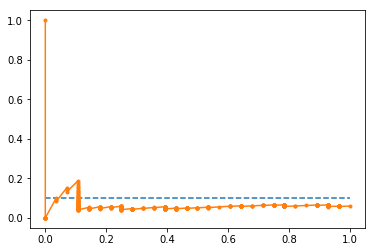

LBP
auc=0.069 ap=0.075


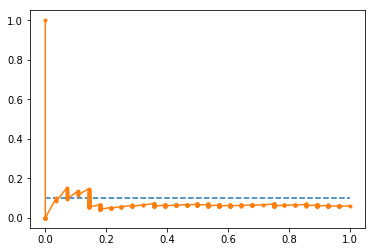

HOG
auc=0.073 ap=0.078


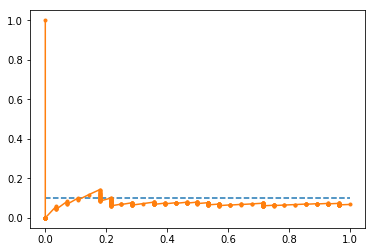

VGG16 untrained
auc=0.064 ap=0.067


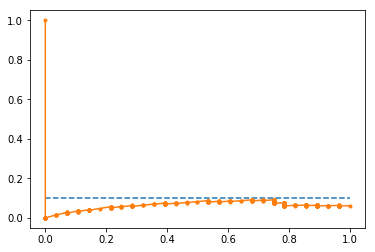

VGG16 trained
auc=0.550 ap=0.552


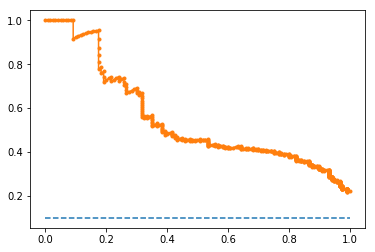

In [175]:
rgb_y_true, rgb_probs = get_probs(features_x_val_rgb, 350, 100, Y_val, Y_val_1)
evaluate(rgb_y_true, rgb_probs, 'RGB')

lbp_y_true, lbp_probs = get_probs(features_x_val_lbp, 0.06, 100,Y_val, Y_val_1)
evaluate(lbp_y_true, lbp_probs, 'LBP')

hog_y_true, hog_probs = get_probs(features_x_val_HOG, 41, 100,Y_val, Y_val_1)
evaluate(hog_y_true, hog_probs, 'HOG')

vgg_y_true, vgg_probs = get_probs(features_x_val_VGG16, 290, 100,Y_val, Y_val_1)
evaluate(vgg_y_true, vgg_probs, 'VGG16 untrained')

vgg_tr_y_true, vgg_tr_probs = get_probs(features_x_train_vgg_tr, 14, 100,y_train, y_train_1)
evaluate(vgg_tr_y_true, vgg_tr_probs, 'VGG16 trained')

Based on the precision and recall values and the AUC of the precision-recall curves, the best performing feature representation is the Keras pretrained VGG16 model that I also trained on the cifar-10 images.
I used this representation for the final testing of the image retrieval task

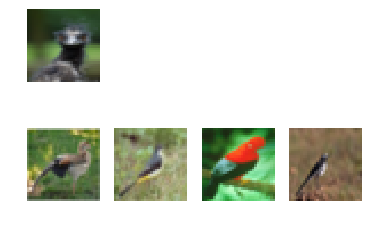

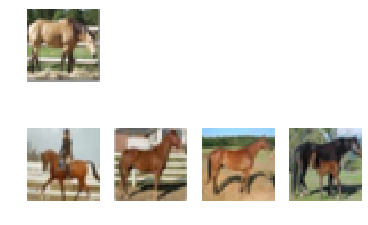

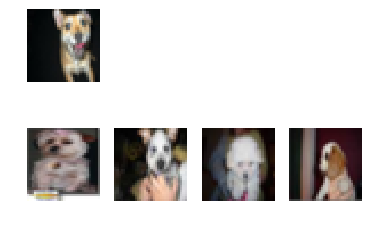

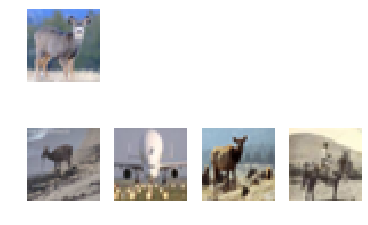

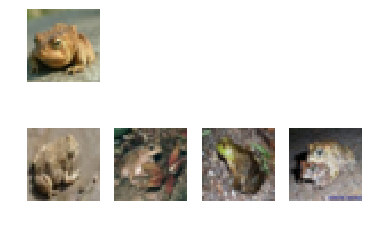

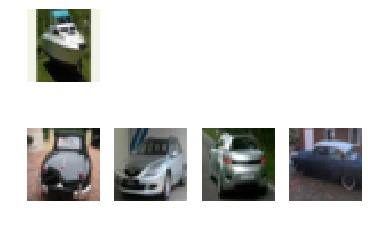

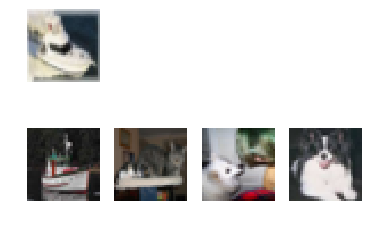

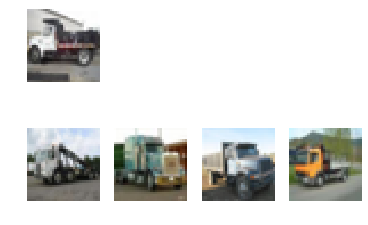

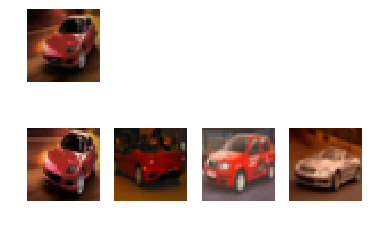

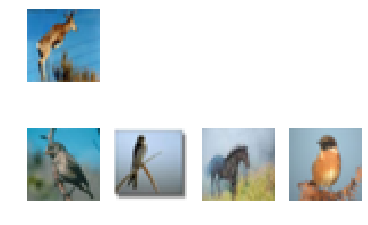

In [177]:
import random
from sklearn.neighbors import KDTree
randoms = random.sample(range(0, 10000), 10)
tree = KDTree(features_x_train_vgg_tr)
for i in randoms:
    x = image.img_to_array(x_test[i])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    f = sub_model.predict(x).flatten()
    nearest_dist, nearest_ind = tree.query(f.reshape(1, -1), k=4)
    plt.figure(1)
    plt.axis('off')
    plt.subplot(241)
    plt.imshow(x_test[i])
    plt.axis('off')

    plt.subplot(245)
    plt.imshow(x_train[nearest_ind[0][0]])
    plt.axis('off')
    plt.subplot(246)
    plt.imshow(x_train[nearest_ind[0][1]])
    plt.axis('off')
    plt.subplot(247)
    plt.imshow(x_train[nearest_ind[0][2]])
    plt.axis('off')
    plt.subplot(248)
    plt.imshow(x_train[nearest_ind[0][3]])
    plt.axis('off')
    plt.show()


As can be seen from the retrieved images, this feture representation works well because for each query image, similar images (belonging to the same class) are retrieved